# Interactive Learning Course
## HW #2, Multi-Armed Bandits

In [1]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt
from random import choice

# Part 2

## Reward class

In [2]:
class Reward(ABC):
    def __init__(self, debts=[5.0, 20.0, 100.0]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [3]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1])
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05])
        
        return obs, round(obs - self.debts[action],5)

In [4]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, round(obs - self.debts[action],5)

In [5]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, round(obs - self.debts[action],5)

## Environment

In [6]:
class Environment:
    def __init__(self, id):
        self.state=id
        self.action=[0,1,2]
#         self.opt_action_value=[0.1,0.75,5]
        
    def calc_reward(self, action):
        self.reward=0
        if self.state == 0: self.reward=Student().get_reward(action)
        elif self.state == 1: self.reward=GovStaff().get_reward(action)
        elif self.state == 2: self.reward=SelfEmp().get_reward(action)
        return self.reward
    
    def get_available_actions(self):
        return self.action

# Part 3

In [7]:
class agent:
    def __init__(self,env,alpha=0, beta=1, gamma=1):
        self.id=env
        self.Q=[0]*len(Environment(self.id).get_available_actions())
        self.N=[0]*len(Environment(self.id).get_available_actions())
        self.R_greedy=[]
        self.R_ucb=[]
        self.R_GB=[]
        self.regret_greedy=[]
        self.regret_ucb=[]
        self.regret_GB=[]
        self.beta=beta
        self.alpha=alpha
        self.gamma=gamma
    
    
    def utility(self,r):
        return (self.beta*r**self.gamma)+self.alpha
    
    
    def e_greedy(self,epsilon=0.2,trial=100):
        for i in range(1,trial+1): 
            self.A=np.random.choice([np.argmax(self.Q,axis=0),choice(Environment(id).get_available_actions())]
                                    ,p=[1-epsilon,epsilon])
            
            #print("Action:%d"%self.A)
            reward=Environment(self.id).calc_reward(self.A)[1]
            #print("Reward:%.2f"%reward)
            self.N[self.A]+=1
            #print("Counter of Actions:",self.N)
            self.Q[self.A]+=(1/i)*(self.utility(reward)-self.Q[self.A])
            self.R_greedy.append(self.Q[self.A])
            #print("Point Estimation:",list(np.round(self.Q,5)))
            #print("-"*15)
            self.regret_greedy=list(5-np.array(self.R_greedy))
        return self.R_greedy,self.regret_greedy
    
    
    def ucb(self,c=2,trial=100):
        self.ucb=[np.inf]*len(Environment(self.id).get_available_actions())
        self.N=[1]*len(Environment(self.id).get_available_actions())
        for i in range(1,trial+1):
            self.A=np.argmax(self.ucb)
            self.ucb=self.Q+c*np.sqrt(np.log(i)/np.array(self.N))
            reward=Environment(self.id).calc_reward(self.A)[1]
            self.N[self.A]+=1
            self.Q[self.A]+=(1/i)*(self.utility(reward)-self.Q[self.A])
            self.R_ucb.append(self.Q[self.A])
            self.regret_ucb=list(5-np.array(self.R_ucb))
    
        return self.R_ucb,self.regret_ucb
    
    def gradient_bandit(self,alpha=0.001,trial=100):
        self.H=[0]*len(Environment(self.id).get_available_actions())
#         self.PI=[1/len(self.H)]*len(Environment(self.id).get_available_actions())
        self.actions=Environment(self.id).get_available_actions()
        for i in range(1,trial+1):
            self.PI=[np.e**self.H[i]/np.sum(np.e**np.array(self.H)) for i in self.actions]
            A=np.random.choice(self.actions,p=self.PI)
            reward=Environment(self.id).calc_reward(A)[1]
            self.R_GB.append(self.utility(reward))
            self.H[A]+=alpha*(self.utility(reward)-
                                   (np.sum(self.R_GB)/len(self.R_GB)))*(1-self.PI[A])
            
            tmp=np.array(self.H)
            tmp=np.delete(tmp,A)
            tmp1=np.array(self.PI)
            tmp1=np.delete(tmp1,A)
            tmp-=alpha*(self.utility(reward)-(np.sum(self.R_GB)/len(self.R_GB)))*(tmp1)
            self.H=list(np.insert(tmp,A,self.H[A]))
            self.PI=list(np.insert(tmp1,A,self.PI[A]))
            self.regret_GB=list(5-np.array(self.R_GB))

        return self.R_GB,self.regret_ucb


In [8]:
# index1 = e-greedy , index1 = Gradient-Based , index1 = UCB
Student_Reward=[0,0,0]
Student_Regret=[0,0,0]
GovStaff_Reward=[0,0,0]
GovStaff_Regret=[0,0,0]
SelfEmp_Reward=[0,0,0]
SelfEmp_Regret=[0,0,0]

In [9]:
Student_Reward[0] = np.array([agent(env=0).e_greedy()[0] for i in range(20)]).mean(axis=0)
Student_Regret[0] = np.array([agent(env=0).e_greedy()[1] for i in range(20)]).mean(axis=0)

Student_Reward[1] = np.array([agent(env=0).ucb()[0] for i in range(20)]).mean(axis=0)
Student_Regret[1] = np.array([agent(env=0).ucb()[1] for i in range(20)]).mean(axis=0)

Student_Reward[2] = np.array([agent(env=0).gradient_bandit()[0] for i in range(20)]).mean(axis=0)
Student_Regret[2] = np.array([agent(env=0).gradient_bandit()[1] for i in range(20)]).mean(axis=0)

GovStaff_Reward[0] = np.array([agent(env=1).e_greedy()[0] for i in range(20)]).mean(axis=0)
GovStaff_Regret[0] = np.array([agent(env=1).e_greedy()[1] for i in range(20)]).mean(axis=0)

GovStaff_Reward[1] = np.array([agent(env=1).ucb()[0] for i in range(20)]).mean(axis=0)
GovStaff_Regret[1] = np.array([agent(env=1).ucb()[1] for i in range(20)]).mean(axis=0)

GovStaff_Reward[2] = np.array([agent(env=1).gradient_bandit()[0] for i in range(20)]).mean(axis=0)
GovStaff_Regret[2] = np.array([agent(env=1).gradient_bandit()[1] for i in range(20)]).mean(axis=0)

SelfEmp_Reward[0] = np.array([agent(env=2).e_greedy()[0] for i in range(20)]).mean(axis=0)
SelfEmp_Regret[0] = np.array([agent(env=2).e_greedy()[1] for i in range(20)]).mean(axis=0)

SelfEmp_Reward[1] = np.array([agent(env=2).ucb()[0] for i in range(20)]).mean(axis=0)
SelfEmp_Regret[1] = np.array([agent(env=2).ucb()[1] for i in range(20)]).mean(axis=0)

SelfEmp_Reward[2] = np.array([agent(env=2).gradient_bandit()[0] for i in range(20)]).mean(axis=0)
SelfEmp_Regret[2] = np.array([agent(env=2).gradient_bandit()[1] for i in range(20)]).mean(axis=0)

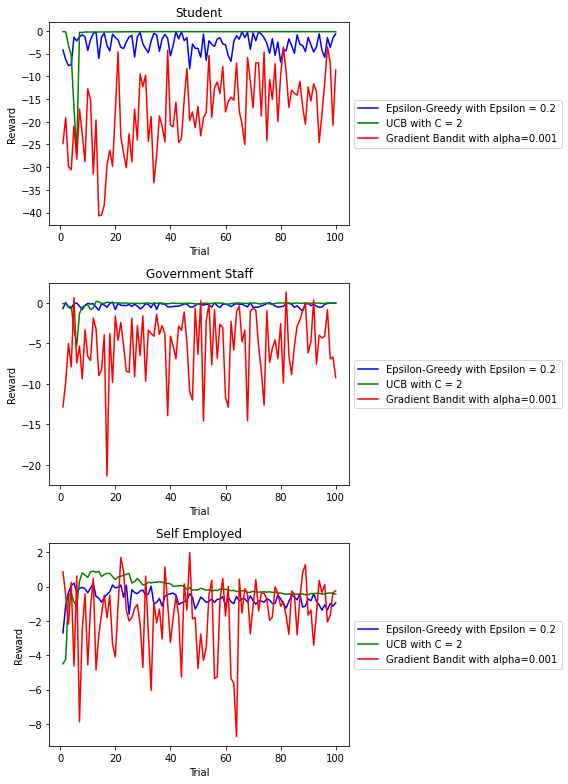

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(8,11))
ax[0].plot(np.arange(1,101,1),Student_Reward[0],c='b',label="Epsilon-Greedy with Epsilon = 0.2")
ax[0].plot(np.arange(1,101,1),Student_Reward[1],c='g',label="UCB with C = 2")
ax[0].plot(np.arange(1,101,1),Student_Reward[2],c='r',label="Gradient Bandit with alpha=0.001")
# ax[0].plot(np.arange(1,101,1),Student_Regret[0],c='r',label="Regret")
# plt.plot(np.arange(1,101,1),[0.1]*100,c='g',label="Reward of Best Action = 0.1")
# plt.fill_between(np.arange(1,101,1),0.1,Student_Reward[0],color="red",alpha=0.2,label="Regret")
# plt.title("E-Greedy with epsilon = 0.2")
ax[0].legend(loc=6, bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel("Reward")
ax[0].set_xlabel("Trial")
ax[0].set_title("Student")


# plt.subplot(3,1,2).title.set_text("Government Staff")
ax[1].plot(np.arange(1,101,1),GovStaff_Reward[0],c='b',label="Epsilon-Greedy with Epsilon = 0.2")
ax[1].plot(np.arange(1,101,1),GovStaff_Reward[1],c='g',label="UCB with C = 2")
ax[1].plot(np.arange(1,101,1),GovStaff_Reward[2],c='r',label="Gradient Bandit with alpha=0.001")

# ax[1].plot(np.arange(1,101,1),GovStaff_Regret[0],c='r',label="Regret")
# plt.plot(np.arange(1,101,1),[0.75]*100,c='g',label="Reward of Best Action = 0.75")
# plt.fill_between(np.arange(1,101,1),0.75,GovStaff_Reward[0],color="red",alpha=0.2,label="Regret")
ax[1].legend(loc=6, bbox_to_anchor=(1, 0.5))
ax[1].set_ylabel("Reward")
ax[1].set_xlabel("Trial")
ax[1].set_title("Government Staff")

# plt.subplot(3,1,3).title.set_text("Self Employee")
ax[2].plot(np.arange(1,101,1),SelfEmp_Reward[0],c='b',label="Epsilon-Greedy with Epsilon = 0.2")
ax[2].plot(np.arange(1,101,1),SelfEmp_Reward[1],c='g',label="UCB with C = 2")
ax[2].plot(np.arange(1,101,1),SelfEmp_Reward[2],c='r',label="Gradient Bandit with alpha=0.001")
# ax[2].plot(np.arange(1,101,1),SelfEmp_Regret[0],c='r',label="Regret")
# plt.plot(np.arange(1,101,1),[5]*100,c='g',label="Reward of Best Action = 5")
# plt.fill_between(np.arange(1,101,1),5,SelfEmp_Reward[0],color="red",alpha=0.2,label="Regret")
ax[2].legend(loc=6, bbox_to_anchor=(1, 0.5))
ax[2].set_ylabel("Reward")
ax[2].set_xlabel("Trial")
ax[2].set_title("Self Employed")
plt.tight_layout()
plt.show()

In [11]:
class Agent:
    def __init__(self, _id, env=None, alpha=0, beta=1, gamma=1):
        self.Q=0
        self.N=0

    def choose_action(self):
        pass    
    def calculate_utility(self, reward):
        pass    
    def take_action(self, action):
        pass
    
    def update_value(self, action, util):
        pass
    def step(self, best_reward, trial):
        pass
    def reset(self):
        pass
    
    def get_rewards(self):
        pass
    
    def get_regrets(self):
        pass